## Classification Attention Analysis

In [1]:
%load_ext autoreload
%autoreload 2

from __future__ import print_function
import keras
from keras import backend as K
import tensorflow as tf

import os
import numpy as np
import pandas as pd
import scipy

import Bio
from Bio import SeqIO
import Bio.motifs

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import model_selection
import sklearn

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from signal_models import *
from utility_functions import *

sns.set_context('notebook')

Using TensorFlow backend.


In [2]:
working_directory = '/home/jtao/analysis/genomic_grammar_analysis/'

## Read Data

In [3]:
treatment_positive_fasta_dict = {}
treatment_negative_fasta_dict = {}
treatment_positive_seqArray_dict = {}
treatment_positive_rc_seqArray_dict = {}
treatment_negative_seqArray_dict = {}
treatment_negative_rc_seqArray_dict = {}

for ps in ['c57bl6_kla-1h_peaks.fasta', 'c57bl6_veh_peaks.fasta', 'c57bl6_il4-24h_peaks.fasta']:
    treatment = ps.split('_')[1]
    print('***',treatment, '***')
    positive_seqRecords = list(SeqIO.parse(working_directory + '/peak_sequences/' + ps, 'fasta'))
    negative_seqRecords = list(SeqIO.parse(working_directory + '/background_files/' + ps.replace('_peaks', '_background'), 'fasta'))[:len(positive_seqRecords)]
    
    positive_fasta_seq = [str(x.seq[:200]) for x in positive_seqRecords]
    negative_fasta_seq = [str(x.seq[:200]) for x in negative_seqRecords]
    
    positive_rc_fasta_seq = [str(x[:200].reverse_complement().seq) for x in positive_seqRecords]
    negative_rc_fasta_seq = [str(x[:200].reverse_complement().seq) for x in negative_seqRecords]
    
    positive_sequence_arrays = convert_sequences_to_array(positive_fasta_seq)
    positive_rc_sequence_arrays = convert_sequences_to_array(positive_rc_fasta_seq)
    
    negative_sequence_arrays = convert_sequences_to_array(negative_fasta_seq)
    negative_rc_sequence_arrays = convert_sequences_to_array(negative_rc_fasta_seq)
    
    treatment_positive_fasta_dict[treatment] = positive_fasta_seq
    treatment_negative_fasta_dict[treatment] = negative_fasta_seq
    treatment_positive_seqArray_dict[treatment] = positive_sequence_arrays
    treatment_positive_rc_seqArray_dict[treatment] = positive_rc_sequence_arrays
    treatment_negative_seqArray_dict[treatment] = negative_sequence_arrays
    treatment_negative_rc_seqArray_dict[treatment] = negative_rc_sequence_arrays

*** kla-1h ***
*** veh ***
*** il4-24h ***


## Set Model Settings

In [147]:
### settings for attention model ###
attention_num_motifs=150
attention_motif_size=16
adjacent_bp_pool_size=1
attention_num_dense_neurons = 1
attention_dropout_rate=0.1

## Read in Models

In [148]:
condition_model_dict = {}
for f in os.listdir(working_directory + '/models_classification/'):
    treatment_modelType = f.replace('_weights.h5','')
    modelType = treatment_modelType.split('_')[0]
    if modelType == 'DotAttention':
        current_model = get_dotProductAttention_model(200,
            mode='classification',
            num_motifs=attention_num_motifs, 
            motif_size=attention_motif_size,
            adjacent_bp_pool_size=adjacent_bp_pool_size,
            num_dense_neurons = attention_num_dense_neurons,
            dropout_rate=attention_dropout_rate,
            num_classes=2)
        current_model.load_weights(working_directory + '/models_classification/' + treatment_modelType + '_weights.h5')
        condition_model_dict[treatment_modelType] = current_model
        print(f, current_model.count_params())

DotAttention_kla-1h_weights.h5 10753
DotAttention_veh_weights.h5 10753
DotAttention_il4-24h_weights.h5 10753


## Get correctly classified sequences

In [149]:
treatment_truePositive_seqArray_dict = {}
for treatment in sorted(treatment_positive_seqArray_dict.keys()):
    positive_sequence_arrays = treatment_positive_seqArray_dict[treatment] 
    
    current_model = condition_model_dict['DotAttention_' + treatment]
    
    probs = current_model.predict([positive_sequence_arrays])
    predictions = np.array([0 if x[0] > x[1] else 1 for x in probs])
    truePositve_sequence_arrays = positive_sequence_arrays[predictions == 1]
    treatment_truePositive_seqArray_dict[treatment] = truePositve_sequence_arrays

    print(treatment, len(truePositve_sequence_arrays)/len(positive_sequence_arrays))

il4-24h 0.9252640372337252
kla-1h 0.9226212343864806
veh 0.8527099841521395


## Weight Extraction

In [155]:
def get_sequence_attention(model, sequence_arrays, sequence_size):
    get_attention = K.function([model.get_layer('input_fwd').input, 
                                K.learning_phase()
                               ], 
                               [model.get_layer('attention_softmax_layer').output])
    trimmed_sequences = [x[:sequence_size] for x in sequence_arrays]
    
    attention = get_attention((trimmed_sequences, 0))[0]

    return attention

In [151]:
treatment_attention_dict = {}
for treatment in sorted(treatment_truePositive_seqArray_dict.keys()):
    print('***',treatment, '***')

    sequence_arrays = treatment_truePositive_seqArray_dict[treatment]
    if 'DotAttention_'+treatment in condition_model_dict:
        current_model = condition_model_dict['DotAttention_'+treatment]

        attention = get_sequence_attention(current_model,
            sequence_arrays,
            200)

        treatment_attention_dict[treatment] = attention


*** il4-24h ***
*** kla-1h ***
*** veh ***


## Visualize Attention

In [165]:
attention = treatment_attention_dict['kla-1h']

### Overall Matrix

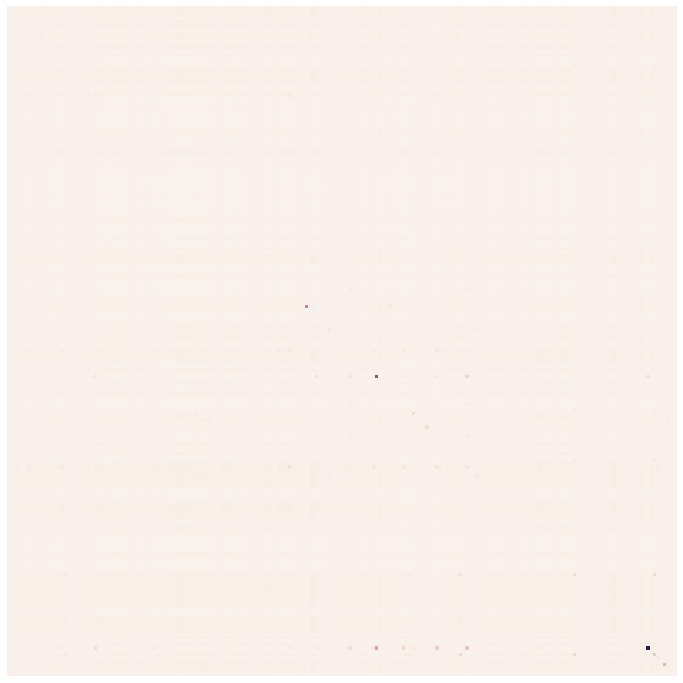

In [170]:
index = 1811
plt.figure(figsize=(15,15))
hm = sns.heatmap(attention[index], 
            yticklabels = False, 
            xticklabels = False, 
            square = True,
           vmin=0,
#            vmax=0.4
           )
cb = hm.collections[0].colorbar
cb.ax.set_visible(False)

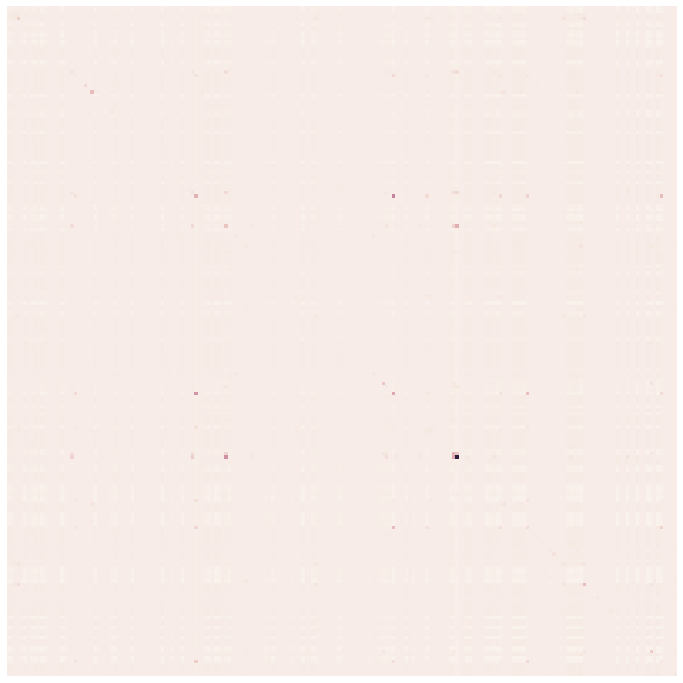

In [169]:
index = 19999
# index = 19996
plt.figure(figsize=(15,15))
hm = sns.heatmap(attention[index], 
            yticklabels = False, 
            xticklabels = False, 
            square = True,
#            vmin=0,
#            vmax=0.1
           )
cb = hm.collections[0].colorbar
cb.ax.set_visible(False)

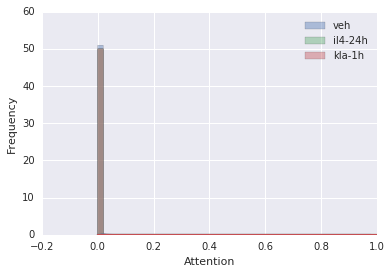

In [139]:
for treatment in treatment_attention_dict:
    treatment_attention = treatment_attention_dict[treatment]
    sns.distplot(treatment_attention[:100].flatten(), label = treatment)
plt.xlabel('Attention')
plt.ylabel('Frequency')
plt.legend()

#### Per sequence frequencies

In [157]:
num_positions = 200
matrix_size = num_positions**2
count_list = []
treatment_list = []
threshold_list = []
for treatment in treatment_attention_dict:
    treatment_attention = treatment_attention_dict[treatment]
    print(treatment)
    
    for threshold in [np.round(x,2) for x in np.arange(0.1,1,0.1)]:
        counter = 0
        print(threshold)
        for am in treatment_attention:
            count = np.sum(am.flatten() > threshold)
            count_list.append(count)
#             normalized_count_list.append(count/matrix_size)
            treatment_list.append(treatment)
            threshold_list.append(threshold)
#             counter+=1
#             if counter % 10000 == 0:
#                 print(counter)

veh
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
il4-24h
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
kla-1h
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


In [158]:
frame = pd.DataFrame({'Treatment': treatment_list, 
                      'Threshold': threshold_list,
                      'Count':count_list})

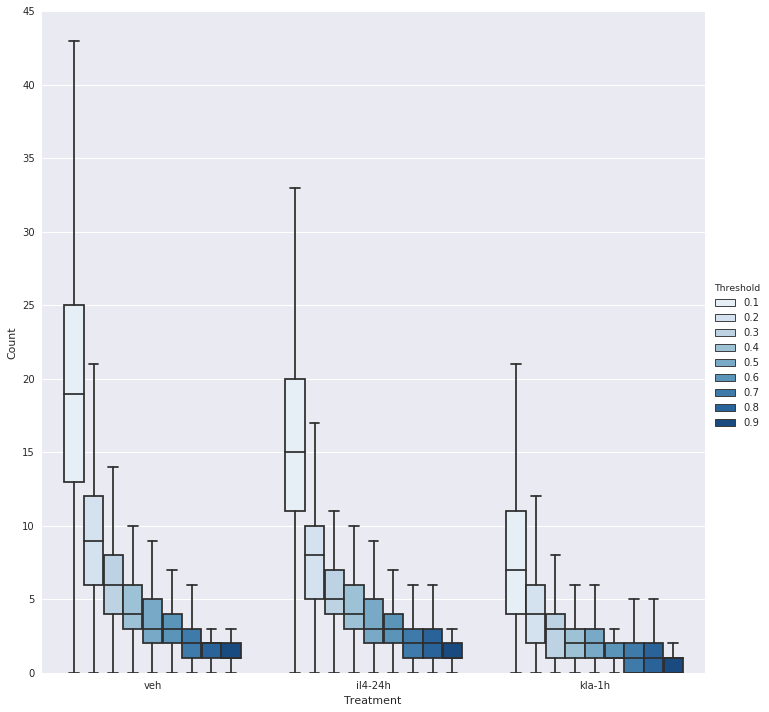

In [159]:
sns.factorplot(data = frame, 
    x = 'Treatment',
    y = 'Count',
    hue='Threshold',
    kind = 'box',
    palette = 'Blues',
    showfliers=False,
    size = 10)

### Max per Position

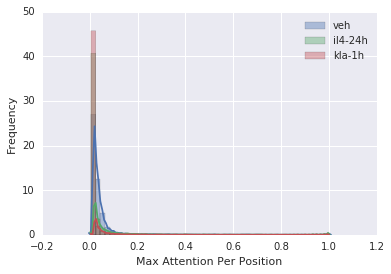

In [160]:
for treatment in treatment_attention_dict:
    treatment_attention = treatment_attention_dict[treatment]
    max_attention = np.array([x.max(axis=0) for x in treatment_attention[:100]])
    sns.distplot(max_attention.flatten(), label = treatment)
plt.xlabel('Max Attention Per Position')
plt.ylabel('Frequency')
plt.legend()

#### Per sequence frequencies

In [161]:
count_list = []
treatment_list = []
threshold_list = []
normalized_count_list = []
for treatment in treatment_attention_dict:
    treatment_attention = treatment_attention_dict[treatment]
    max_attention = np.array([x.max(axis=0) for x in treatment_attention])
    print(treatment)
    for threshold in [np.round(x,2) for x in np.arange(0.1,1,0.1)]:
        for fam in max_attention:
            count = np.sum(fam.flatten() >= threshold)
            count_list.append(count)
            treatment_list.append(treatment)
            threshold_list.append(threshold)
        


veh
il4-24h
kla-1h


In [162]:
frame = pd.DataFrame({'Treatment': treatment_list, 
                      'Threshold': threshold_list,
                      'Count':count_list})

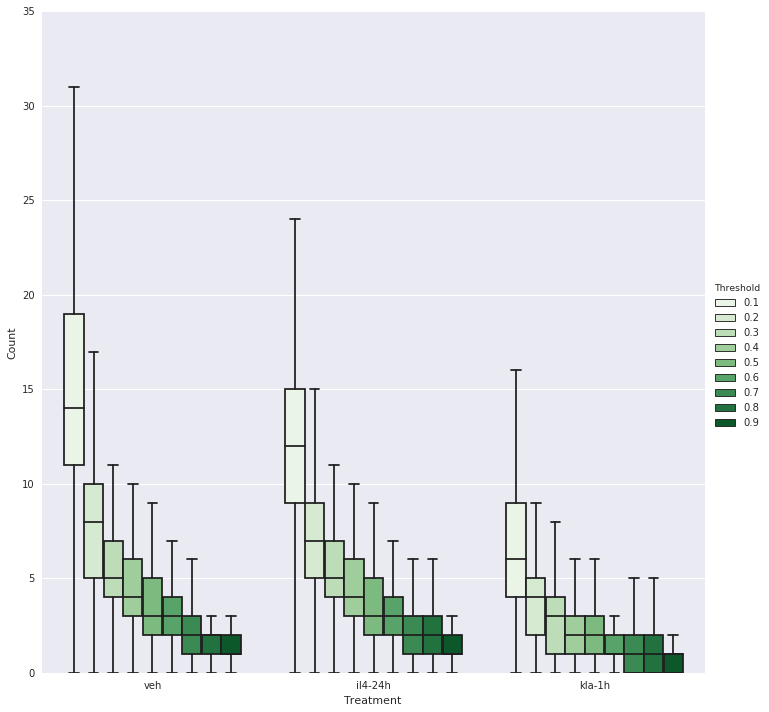

In [163]:
sns.factorplot(data = frame, 
    x = 'Treatment',
    y = 'Count',
    hue='Threshold',
    kind = 'box',
    palette = 'Greens',
    showfliers=False,
    size = 10)


## Motif Extraction